In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from livelossplot import PlotLosses

In [2]:
df = pd.read_csv('data/train.csv',  index_col='5 Minutes')
df = df.astype('float')

<AxesSubplot:xlabel='5 Minutes'>

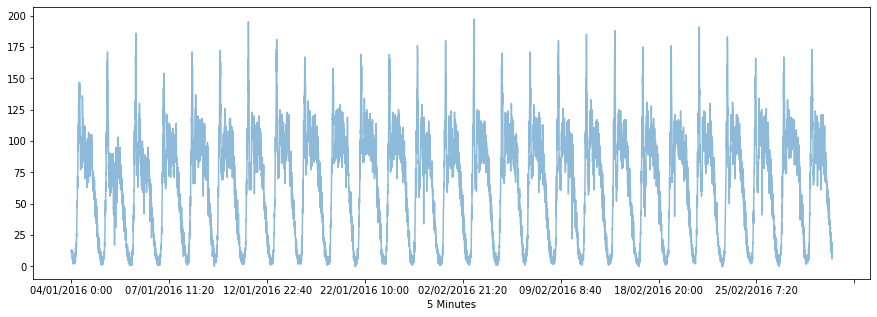

In [3]:
df['Lane 1 Flow (Veh/5 Minutes)'].plot(figsize=(15,5), alpha=0.5)

<AxesSubplot:xlabel='5 Minutes'>

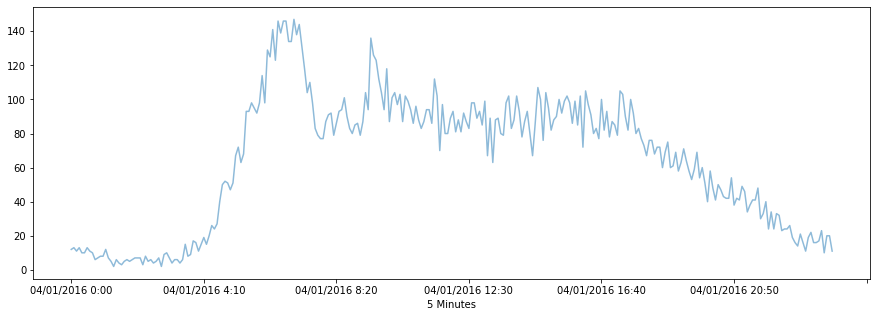

In [4]:
df['Lane 1 Flow (Veh/5 Minutes)'][:int(60*24/5)].plot(figsize=(15,5), alpha=0.5)

In [5]:
def create_data(df):
    indexs = list(df.index)
    indexs = [[i.split(' ')[0],i.split(' ')[1]] for i in indexs]
    # 生成了 xx xx xx xx
    indexs = [[dt[0].split('/')[0],dt[0].split('/')[1],dt[1].split(':')[0], dt[1].split(':')[1]] for dt in indexs]
    date_times = np.array(indexs).astype('float')
    flows = np.array(df['Lane 1 Flow (Veh/5 Minutes)'])
    # 维度弥补
    flows = flows[:,np.newaxis].astype('float')
    data = np.concatenate((date_times, flows),axis=1)
#     mean = np.mean(data, axis=1)
#     std = np.std(data, axis=1)
#     data = (data-mean)/std
    return data

In [6]:
data = create_data(df)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_mean = np.mean(data,axis=0)
data_std = np.std(data,axis=0)
data = (data-data_mean)/data_std

train_x = data[:-1]
train_y = data[1:,4]
train_x = torch.as_tensor(torch.from_numpy(train_x), dtype=torch.float32)
train_y = torch.as_tensor(torch.from_numpy(train_y), dtype=torch.float32)

In [8]:
input_size = train_x.shape[1]
output_size = 1
hidden_size = 10
num_layers = 1
seq_len = 128
batch_size = 32
train_size = train_x.shape[0]

In [30]:
batch_var_x = []
batch_var_y = []

for i in range(train_size):
    j = train_size - i
    k = j + seq_len
    batch_var_x.append(train_x[j:k])
    batch_var_y.append(train_y[j:k])
    
batch_var_x = pad_sequence(batch_var_x, batch_first = True)
batch_var_y = pad_sequence(batch_var_y, batch_first = True)

In [14]:
from torch.utils.data import DataLoader, Dataset


class Traffic_Dateset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

train_set = Traffic_Dateset(batch_var_x, batch_var_y)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)

In [9]:
class RegLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RegLSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        self.reg = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )
    
    def forward(self, x):
        y = self.rnn(x)[0]
        batch_size, seq_len, hidden_size = y.shape
        y = y.contiguous().view(-1, hidden_size)
        
        y = self.reg(y)
        y = y.view(batch_size, seq_len, -1)
        
        return y

In [11]:
with torch.no_grad():
    weights = np.tanh(np.arange(seq_len) * (np.e / seq_len))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [18]:
epoch = 230
net = RegLSTM(input_size, hidden_size, output_size, num_layers).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)


loss_value_list = []
e_tqdm = tqdm(range(epoch))
for e in e_tqdm:
    loss_value = 0
    for i,data in enumerate(train_loader):
        d_x, d_y = data
        pred_y = net(d_x.cuda())
        
        
        gap = pred_y-d_y[:,:,np.newaxis].cuda()
        gap = gap.view(-1,seq_len)
        loss = gap**2*weights
        loss = loss.mean()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_value += loss.item()
        
    loss_value_list.append(loss_value)
    e_tqdm.set_description('Epoch: {:4}, Loss: {:.5f}'.format(e, loss_value))


Epoch:  229, Loss: 7.46697: 100%|██████████| 230/230 [12:20<00:00,  3.22s/it]


In [34]:
def test():
    df = pd.read_csv('data/test.csv',  index_col='5 Minutes')
    df = df.astype('float')

    data = create_data(df)
    data = (data-data_mean)/data_std

    test_x = data[:-1]
    test_y = data[1:,4]
    test_x = torch.as_tensor(torch.from_numpy(test_x), dtype=torch.float32)
    test_y = torch.as_tensor(torch.from_numpy(test_y), dtype=torch.float32)

    return test_x, test_y

In [29]:
test_x, test_y = test()

In [33]:
net.eval()
net(test_x[0:3].view(1,3,-1).cuda())

NameError: name 'test_x' is not defined

In [31]:
test_y

tensor([-1.3877, -1.3633, -1.3633,  ..., -1.1194, -1.0706, -1.2902])

# 表现的太差了，我们试一试不用batch

In [41]:
batch_size = 12 *24  *7
seq_len = batch_size - 1

batch_var_x = []
batch_var_y = []
for i in range(batch_size):
        j = train_size - i
        batch_var_x.append(train_x[j:])
        batch_var_y.append(train_y[j:])

batch_var_x = pad_sequence(batch_var_x, batch_first = True)
batch_var_y = pad_sequence(batch_var_y, batch_first = True)

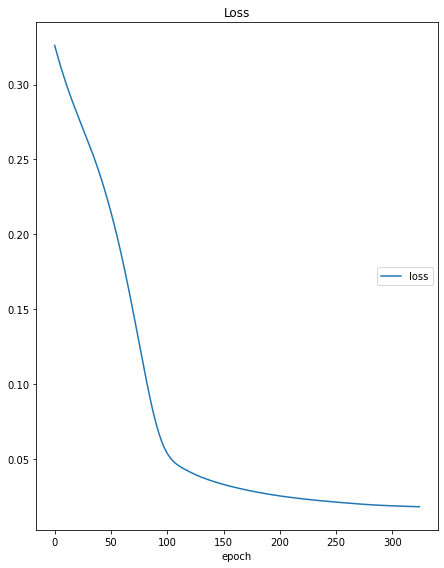

In [46]:
with torch.no_grad():
    weights = np.tanh(np.arange(seq_len) * (np.e / seq_len))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)


epoch = 1000
net = RegLSTM(input_size, hidden_size, output_size, num_layers).cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

net.train()

p_loss = PlotLosses()
logs = {}

loss_value_list = []
e_tqdm = tqdm(range(epoch))
for e in e_tqdm:
    pred_y = net(batch_var_x.cuda())

    loss = ((pred_y - batch_var_y[:,:,np.newaxis].cuda()).view(-1, seq_len) **2 * weights)
    loss = loss.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_value_list.append(loss.item())
    logs['loss'] = loss.item()
    e_tqdm.set_description('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))

    p_loss.update(logs)
    p_loss.send()
    


In [43]:
'''testing'''
net.eval()


RegLSTM(
  (rnn): LSTM(5, 10, batch_first=True)
  (reg): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [19]:
batch_var_x[-1][:,-1]

tensor([-1.2658, -1.3146, -1.1926,  ..., -1.4853, -1.2902, -1.3633])

In [44]:
pred_x_1 = net(batch_var_x[-1].view(-1,seq_len,5).cuda()).view(-1).cpu().detach().numpy()

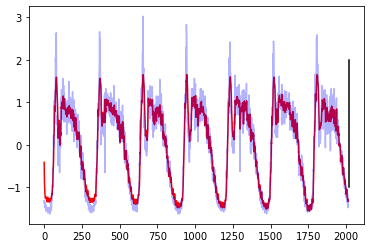

In [45]:

plt.plot(pred_x_1, 'r', label='pred')
plt.plot(batch_var_y[-1], 'b', label='real', alpha=0.3)
plt.plot([batch_size, batch_size], [-1, 2], color='k', label='train | pred')